In [1]:
import obspy as op
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import tensorflow as tf
import model_V1
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')

print (tf.config.list_physical_devices())
print (tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  #Invalid device or cannot modify virtual devices once initialized.
  pass

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.5.0


In [ ]:
save_dir = "./results/temp"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Training Autoencoder

In [2]:
'''
###loading data
x_train = np.load('./x.npy',mmap_mode='r')
y_train = np.load('./y.npy',allow_pickle=True)
print (x_train.shape)

###make noisy data
def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """
    noise_factor = 0.2
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=3.0, size=array.shape
    )
    return noisy_array

x_train_noisy = noise(x_train)

###building model
encoder,decoder,autoencoder = model_V1.CAE(input_shape=(128, 128, 3), filters=[12, 24, 36, 48, 64], summary=True)
    
###training 
autoencoder.compile(optimizer='adam', loss='mse')
csv_logger = tf.keras.callbacks.CSVLogger(save_dir + '/pretrain_log.csv')
history = autoencoder.fit(x_train_noisy, x_train,
                          batch_size = 256,
                          epochs = 200,
                          callbacks=[csv_logger]
                          )

WeightsFileName =  ['/Pretrain_encoder.h5','/Pretrain_autoencoder.h5','/Pretrain_decoder.h5']
encoder.save_weights(save_dir + WeightsFileName[0])
autoencoder.save_weights(save_dir + WeightsFileName[1])
decoder.save_weights(save_dir + WeightsFileName[2])
'''

(47049, 128, 128, 3)
Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_img (InputLayer)    [(None, 128, 128, 3)]     0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 64, 64, 12)        336       
_________________________________________________________________
Conv_2 (Conv2D)              (None, 32, 32, 24)        2616      
_________________________________________________________________
Conv_3 (Conv2D)              (None, 16, 16, 36)        7812      
_________________________________________________________________
Conv_4 (Conv2D)              (None, 8, 8, 48)          15600     
_________________________________________________________________
Flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
encoded (Dense)              (None

184/184 [==============================] - 7s 38ms/step - loss: 0.1583
Epoch 141/200
184/184 [==============================] - 7s 39ms/step - loss: 0.1583
Epoch 142/200
184/184 [==============================] - 7s 39ms/step - loss: 0.1583
Epoch 143/200
184/184 [==============================] - 7s 38ms/step - loss: 0.1583
Epoch 144/200
184/184 [==============================] - 7s 39ms/step - loss: 0.1582
Epoch 145/200
184/184 [==============================] - 7s 38ms/step - loss: 0.1582
Epoch 146/200
184/184 [==============================] - 7s 40ms/step - loss: 0.1582
Epoch 147/200
184/184 [==============================] - 7s 39ms/step - loss: 0.1582
Epoch 148/200
184/184 [==============================] - 7s 39ms/step - loss: 0.1582
Epoch 149/200
184/184 [==============================] - 7s 39ms/step - loss: 0.1581
Epoch 150/200
184/184 [==============================] - 7s 39ms/step - loss: 0.1581
Epoch 151/200
184/184 [==============================] - 7s 39ms/step - loss: 0

# Evalutation

(49152,)
dist1 mean: 0.0 std dev: 1.0
 max: 4.189924716949463 min: -3.241346836090088


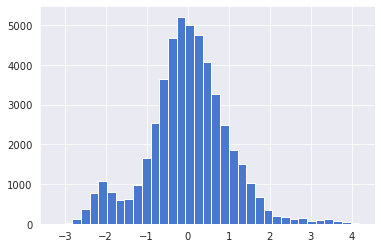

In [2]:
# Loading data
x_train = np.load('./x.npy',mmap_mode='r')
info = np.load('./y.npy',allow_pickle=True)
y_train = info[...,3]


z = (x_train[0][...])
z = z.reshape(128*128*3)
print (z.shape)
print(f'dist1 mean: {np.mean(z)} std dev: {np.std(z)}\n max: {np.max(z)} min: {np.min(z)}')
plt.hist(z, bins = 35)
plt.show()
del z

In [3]:
###building model
encoder,decoder,autoencoder = model_V1.CAE(input_shape=(128, 128, 3), set_seed=[False,42],filters=[12, 24, 36, 48, 64],summary=True)
os.chdir('/home/rick/HDD_16T_a/SapWorkdir/DEC/FinalCode/results/temp')
### Load Pretraining weights
WeightsFileName =  ['./Pretrain_encoder.h5','./Pretrain_autoencoder.h5','./Pretrain_decoder.h5']
encoder.load_weights(WeightsFileName[0])
autoencoder.load_weights(WeightsFileName[1])
decoder.load_weights(WeightsFileName[2])

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_img (InputLayer)    [(None, 128, 128, 3)]     0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 64, 64, 12)        336       
_________________________________________________________________
Conv_2 (Conv2D)              (None, 32, 32, 24)        2616      
_________________________________________________________________
Conv_3 (Conv2D)              (None, 16, 16, 36)        7812      
_________________________________________________________________
Conv_4 (Conv2D)              (None, 8, 8, 48)          15600     
_________________________________________________________________
Flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
encoded (Dense)              (None, 64)                

In [4]:
features = encoder.predict(x_train)
print('feature shape=', features.shape)

feature shape= (47049, 64)


## Number of clusters,K

In [5]:
import metrics
metrics_list_pretrain = []
features = encoder.predict(x_train)
for i in range(2,15):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=20).fit(features)
    y_pred = kmeans.predict(features)
    truelist,predlist,predlist_km = metrics.tracker(y_train,y_pred,n_clusters=i)
    y_pred_last = y_pred
    nmi = metrics.nmi(truelist,predlist_km)
    ari = metrics.ari(truelist,predlist_km)
    purity = metrics.purity_score(truelist,predlist_km)
    print('nmi={0},ari={1},purity={2}'.format(nmi,ari,purity))
    metric=[i,nmi,ari,purity]
    metrics_list_pretrain.append(metric)
    del y_pred
print (metrics_list_pretrain)

in cluster0 : EQnum=526,RFnum=39,ENnum=16,carnum=35
clster0->EQclass
in cluster1 : EQnum=12,RFnum=485,ENnum=522,carnum=316
clster1->ENclass
nmi=0.42861078713711953,ari=0.32755511845217383,purity=0.5371604305484367
in cluster0 : EQnum=502,RFnum=12,ENnum=2,carnum=0
clster0->EQclass
in cluster1 : EQnum=1,RFnum=141,ENnum=5,carnum=118
clster1->RFclass
in cluster2 : EQnum=35,RFnum=371,ENnum=531,carnum=233
clster2->ENclass
nmi=0.46885374366730703,ari=0.357529581058881,purity=0.601742696053306
in cluster0 : EQnum=395,RFnum=5,ENnum=0,carnum=0
clster0->EQclass
in cluster1 : EQnum=0,RFnum=0,ENnum=536,carnum=0
clster1->ENclass
in cluster2 : EQnum=1,RFnum=131,ENnum=1,carnum=124
clster2->RFclass
in cluster3 : EQnum=142,RFnum=388,ENnum=1,carnum=227
clster3->RFclass
nmi=0.642035706893446,ari=0.5556977274323378,purity=0.743208610968734
in cluster0 : EQnum=0,RFnum=0,ENnum=533,carnum=0
clster0->ENclass
in cluster1 : EQnum=1,RFnum=154,ENnum=1,carnum=108
clster1->RFclass
in cluster2 : EQnum=329,RFnum=72,EN

No handles with labels found to put in legend.


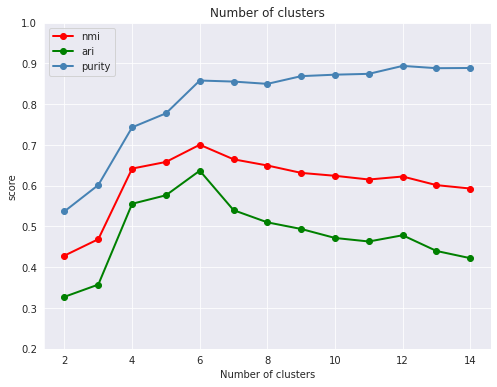

In [6]:
plt.figure(figsize=(8,6))
nmi = [i[1] for i in metrics_list_pretrain]
ari = [i[2] for i in metrics_list_pretrain]
purity = [i[3] for i in metrics_list_pretrain]
clusters = [i[0] for i in metrics_list_pretrain]

plt.plot(clusters, nmi,'o-',  color='red', linewidth=2)
plt.plot(clusters, ari,'o-',  color='g', linewidth=2)
plt.plot(clusters , purity,'o-', color='steelblue' , linewidth=2)


plt.title('Number of clusters')
plt.legend()
plt.xlabel('Number of clusters')
plt.ylabel('score')
plt.legend(["nmi","ari","purity"])
plt.ylim([0.2, 1.0])
plt.yticks()
plt.show()
plt.close()

In [7]:
### initializing the weights using Kmean and assigning them to the model
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters,random_state=87).fit(features)
y_pred = kmeans.fit_predict(features)
y_pred_last = np.copy(y_pred)

In [8]:
# 使用 t-SNE 對 `encodedConv2D_imgs` 資料降維
centers = kmeans.cluster_centers_
reconstruction_centers = decoder.predict(centers)
enc_cen = np.append(features,centers,axis=0)
redu = TSNE(n_components=2, perplexity=30, random_state=87).fit_transform(enc_cen)

/home/rick/anaconda3/envs/tf-2.5/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/home/rick/anaconda3/envs/tf-2.5/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


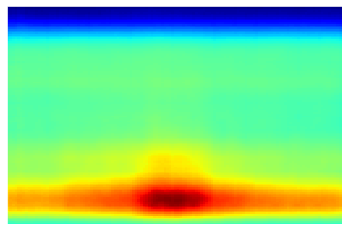

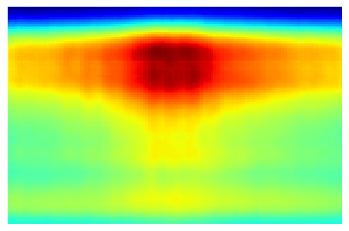

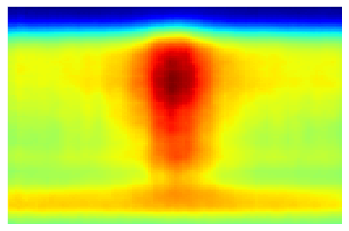

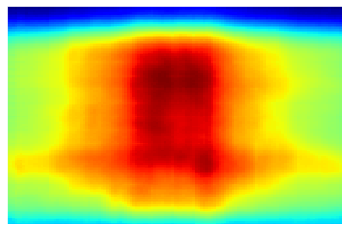

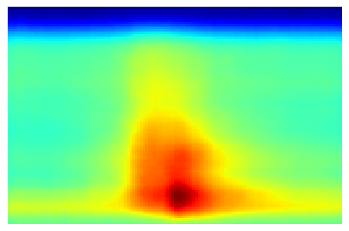

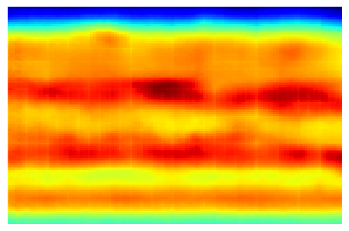

In [9]:
for i,n in enumerate(reconstruction_centers):
    Sxx = reconstruction_centers[i][...,0]
    plt.pcolormesh(Sxx ,cmap='jet')
    plt.axes().get_xaxis().set_visible(False)
    plt.axes().get_yaxis().set_visible(False)
    num = str(i)
    plt.show()
    plt.close()

## Visualization

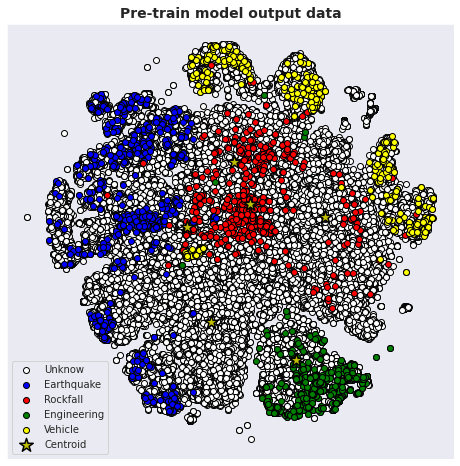

In [10]:
y_true =  np.ndarray(shape=(len(y_train)) ,dtype = 'float32')
for i,data in enumerate(y_train):
    #print (i,data)
    if data == "EQ" :
        y_true[i] = np.array(1)
    elif data == "RF":
        y_true[i] = np.array(2)
    elif data == "EN":
        y_true[i] = np.array(3)
    elif data == "car":
        y_true[i] = np.array(4)
    else :
        y_true[i] = np.array(0)
        
# 在 1x2 的網格上繪製子圖形
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
cen = int(len(reconstruction_centers))
# 調整圖形的外觀
colors = ['white', 'blue', 'red','green','yellow']
for i in range(len(colors)):
    x = redu[:-cen, 0][y_true == i]
    y = redu[:-cen, 1][y_true == i] 
    ax.scatter(x, y, c=colors[i] ,marker='o', edgecolors='black')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
#centers
x1 = redu[-cen:, 0] 
y1 = redu[-cen:, 1]
ax.scatter(x1, y1,s=200, alpha=1, linewidths=1.5, c='y' ,marker='*', edgecolors='black')    
plt.grid()
plt.legend(['Unknow','Earthquake','Rockfall','Engineering','Vehicle','Centroid'])
plt.title("Pre-train model output data", fontsize=14, fontweight='bold')
plt.show()
#fig.savefig(save_dir +"/pretrain_model_output.jpg",dpi=1080,bbox_inches='tight', transparent=False) 
plt.close(fig)

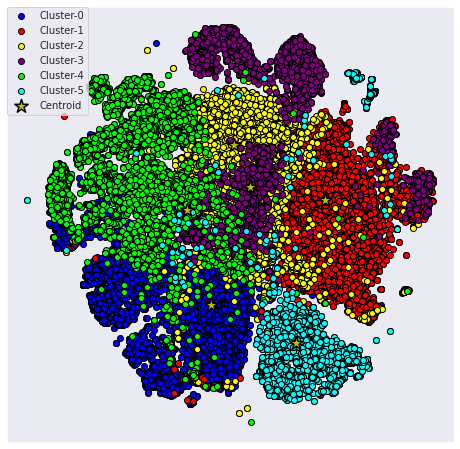

In [11]:
# 在 1x2 的網格上繪製子圖形
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
num = []
for i in range(cen):
    classnum=('Cluster-'+str(i))
    num.append(classnum)
num.append('Centroid')
# 調整圖形的外觀
colors = ['blue', 'red', 'yellow', 'purple', 'lime', 'cyan']
for i in range(len(colors)):
    x = redu[:-cen , 0][y_pred_last == i] 
    y = redu[:-cen , 1][y_pred_last == i] 

    ax.scatter(x, y, c=colors[i] ,marker='o', edgecolors='black')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
#centers
x0 = redu[-cen :, 0] 
y0 = redu[-cen :, 1]
ax.scatter(x0, y0,s=200, alpha=1, linewidths=1.5, c='y' ,marker='*', edgecolors='black')    
plt.legend(num, borderaxespad=0.)
plt.show()
#fig.savefig(save_dir +"/pretrain_model_output_2.jpg",dpi=1080,bbox_inches='tight', transparent=False) 
plt.close(fig)

## Model Performace

in cluster0 : EQnum=171,RFnum=1,ENnum=0,carnum=0
clster0->EQclass
in cluster1 : EQnum=1,RFnum=86,ENnum=1,carnum=113
clster1->ENclass
in cluster2 : EQnum=11,RFnum=237,ENnum=0,carnum=0
clster2->RFclass
in cluster3 : EQnum=2,RFnum=176,ENnum=2,carnum=238
clster3->ENclass
in cluster4 : EQnum=353,RFnum=24,ENnum=0,carnum=0
clster4->EQclass
in cluster5 : EQnum=0,RFnum=0,ENnum=535,carnum=0
clster5->ENclass


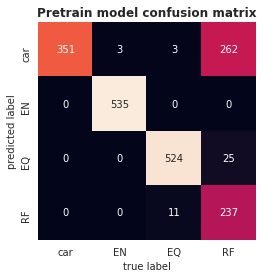

In [12]:
import metrics

truelist,predlist,predlist_km = metrics.tracker(y_train,y_pred_last,n_clusters=n_clusters)
mat = confusion_matrix(truelist,predlist)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=['car','EN','EQ','RF'], yticklabels=['car','EN','EQ','RF']
            )
plt.title("Pretrain model confusion matrix", fontsize=12, fontweight='bold')
plt.xlabel('true label')
plt.ylabel('predicted label')
#plt.savefig(save_dir + "/Pretrain model confusion matrix.jpg",bbox_inches='tight', transparent=False) 
plt.show()
plt.close()

In [13]:
print('nmi=', metrics.nmi(truelist,predlist_km), 'ari=', metrics.ari(truelist,predlist_km))
Purity = []
purity = metrics.purity_score(truelist,predlist_km)
print ("Purity : ", purity)
Purity.append(purity)

nmi= 0.691214628572 ari= 0.623285630935
Purity :  0.844182470528


## Class Assignments 

[11607, 11801, 6825, 5347, 7830, 3639]


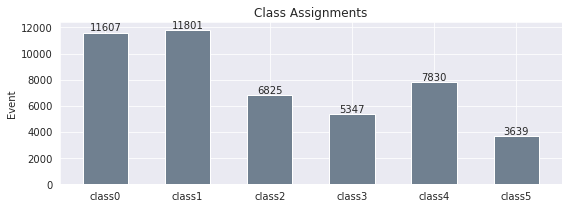

In [14]:
cen = int(len(reconstruction_centers))
classes = []
num = []
for i in range(cen):
    classnum=('class'+str(i))
    classx = np.sum(y_pred_last==i)
    num.append(classx)
    classes.append(classnum)
print (num)
fig, ax = plt.subplots(figsize=(8, 3))
ax.bar(classes, num, tick_label=classes, width=0.55, color='slategray')
ax.set_title('Class Assignments')        
#ax.set_xlabel('Class')                             
ax.set_ylabel('Event')
rect = ax.patches
for rect, num  in zip(rect, num ):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, num,
            ha='center', va='bottom')
fig.tight_layout()
#plt.savefig(save_dir + "/Class Assignments.png",bbox_inches='tight', transparent=False)
plt.show()
plt.close()